In [164]:
import json
path_to_original_dataset = '/Users/anerishah/Desktop/DL/hateful-memes/datasets/hateful_memes'
dev_unseen_file = open(f'{path_to_original_dataset}/dev_unseen.jsonl')
dev_seen_file = open(f'{path_to_original_dataset}/dev_seen.jsonl')
train_file = open(f'{path_to_original_dataset}/train.jsonl')
dev_unseen = []
dev_seen = []
train = []
for line in dev_unseen_file:
    dev_unseen.append(json.loads(line))
for line in dev_seen_file:
    dev_seen.append(json.loads(line))
for line in train_file:
    train.append(json.loads(line))

In [194]:
import shutil
shutil.copyfile(f'{path_to_original_dataset}/train.jsonl', f"{path_to_original_dataset}/train_dev.jsonl")
shutil.copyfile(f'{path_to_original_dataset}/train.jsonl', f"{path_to_original_dataset}/train_dev_transform_half.jsonl")
shutil.copyfile(f'{path_to_original_dataset}/train.jsonl', f"{path_to_original_dataset}/train_dev_transform_all.jsonl")
shutil.copyfile(f'{path_to_original_dataset}/train.jsonl', f"{path_to_original_dataset}/train_dev_transform_all_combined.jsonl")

'/Users/anerishah/Desktop/DL/hateful-memes/datasets/hateful_memes/train_dev_transform_all.jsonl'

In [166]:
dev_seen_ids = [i['id'] for i in dev_seen]
dev_unseen_ids = [i['id'] for i in dev_unseen]

In [167]:
print("original", len(train))
train_dev = []
for i in range(len(dev_seen_ids)):
    seen_id = dev_seen_ids[i]
    if seen_id not in dev_unseen_ids:
        train_dev.append(dev_seen[i])

original 8500


In [168]:
with open(f'{path_to_original_dataset}/train_dev.jsonl', "a") as train_dev_file:
    for entry in train_dev:
        json.dump(entry, train_dev_file)
        train_dev_file.write("\n")

In [169]:
import albumentations as A
import cv2

In [181]:
import matplotlib.pyplot as plt
import random

train_ids = [i['id'] for i in train_dev]
train_size_original = len(train_dev)

def visualize(image):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)

images_folder = f'{path_to_original_dataset}/img/'
target_images_folder = f'{path_to_original_dataset}/img/transform/'

def transform_color(train):
    for original in train:
        img_id = original['id']
        image = cv2.imread(images_folder + img_id + '.png')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
        color_transform = A.Compose(
            [A.AdvancedBlur(p=1),
                A.OpticalDistortion(distort_limit=5, p=1),
                A.HueSaturationValue(p=1)])

        augmented_image = transform(image=image)['image']
        cv2.imwrite(target_images_folder + 'color/' + img_id + '.png', augmented_image) 

def transform_geometric(train):
    for original in train:
        img_id = original['id']
        image = cv2.imread(images_folder + img_id + '.png')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
        color_transform = A.Compose(
            [A.Transpose(p=1),
                A.ElasticTransform(p=1),
                A.ShiftScaleRotate(p=1),
                A.Affine(shear=45, p=1)])
        
        augmented_image = transform(image=image)['image']
        cv2.imwrite(target_images_folder + 'geo/' + img_id + '.png', augmented_image)

def transform_color_geometric(train):
    for original in train:
        img_id = original['id']
        image = cv2.imread(images_folder + img_id + '.png')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        color_transform = A.Compose(
            [A.AdvancedBlur(p=1),
                A.OpticalDistortion(distort_limit=5, p=1),
                A.HueSaturationValue(p=1),
                A.Transpose(p=1),
                A.ElasticTransform(p=1),
                A.ShiftScaleRotate(p=1),
                A.Affine(shear=45, p=1)])
        
        augmented_image = transform(image=image)['image']
        cv2.imwrite(target_images_folder + 'comb/' + img_id + '.png', augmented_image)

def write_to_json(datalist, path):
    with open(path, "a") as f:
        for entry in datalist:
            json.dump(entry, f)
            f.write("\n")

In [172]:
composite_train = train + train_dev
print(len(composite_train))

8600


In [184]:
transform_color(composite_train)

In [185]:
transform_geometric(composite_train)

In [186]:
transform_color_geometric(composite_train)

In [191]:
# 50% randomly color augmented and 50% randomly geometrically augmented (2x the size of train_dev)
def create_half_half_augmented(train):
    augmented_list = []
    train_size_original = len(train)
    random_color_transform_idx = random.sample(range(1, train_size_original), round(0.5 * train_size_original))
    random_geometric_transform_idx = random.sample(range(1, train_size_original), round(0.5 * train_size_original))
    for idx in random_color_transform_idx:
        original = train[idx]
        img_id = original['id']
        new_entry = original.copy()
        new_entry['img'] = 'img/transform/color/' + img_id + '.png'
        augmented_list.append(new_entry)
    for idx in random_geometric_transform_idx:
        original = train[idx]
        img_id = original['id']
        new_entry = original.copy()
        new_entry['img'] = 'img/transform/geo/' + img_id + '.png'
        augmented_list.append(new_entry)
    print(len(augmented_list))
    write_to_json(augmented_list, f'{path_to_original_dataset}/train_dev_transform_half.jsonl')

# all pictures separately augmented with color transformations and geometric transformations (3x the size of train_dev)
def create_all_augmented(train):
    augmented_list = []
    train_size_original = len(train)
    for idx in range(len(train)):
        original = train[idx]
        img_id = original['id']

        # add the color transformed image
        new_color_entry = original.copy()
        new_color_entry['img'] = 'img/transform/color/' + img_id + '.png'
        augmented_list.append(new_color_entry)

        # add the geometrically transformed image
        new_geo_entry = original.copy()
        new_geo_entry['img'] = 'img/transform/geo/' + img_id + '.png'
        augmented_list.append(new_geo_entry)
    print(len(augmented_list))
    write_to_json(augmented_list, f'{path_to_original_dataset}/train_dev_transform_all.jsonl')

# 1 with all pictures augmented with comined color and geometric transformation (2x the size of train_dev)
def create_combined_augmented(train):
    augmented_list = []
    train_size_original = len(train)
    for idx in range(len(train)):
        original = train[idx]
        img_id = original['id']

        new_entry = original.copy()
        new_entry['img'] = 'img/transform/comb/' + img_id + '.png'
        augmented_list.append(new_entry)
    print(len(augmented_list))
    write_to_json(augmented_list, f'{path_to_original_dataset}/train_dev_transform_all_combined.jsonl')

In [188]:
create_half_half_augmented(composite_train)

8600


In [195]:
create_all_augmented(composite_train)

17200


In [190]:
create_combined_augmented(composite_train)

8600


In [193]:
with open(f'{path_to_original_dataset}/train_dev_transform_all.jsonl', "r") as f:
    db = f.readlines()
    for idx, line in enumerate(db):
        db[idx] = json.loads(line.strip("\n"))

[ WARN:0@605174.750] global loadsave.cpp:248 findDecoder imread_('/Users/anerishah/Desktop/DL/hateful-memes/datasets/hateful_memes/img/transform/color/42953.png'): can't open/read file: check file path/integrity


TypeError: Image data of dtype object cannot be converted to float

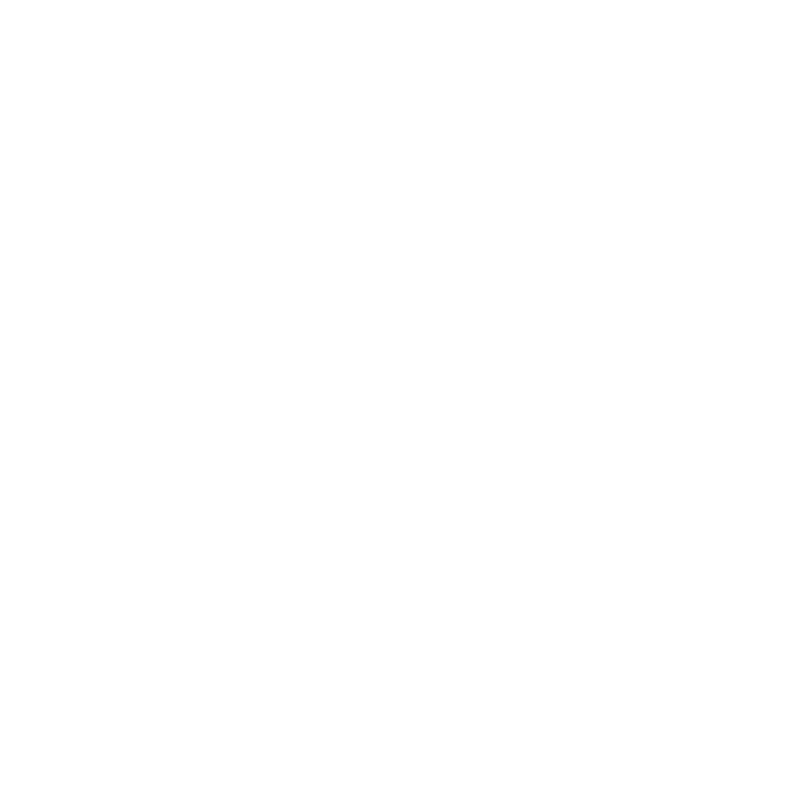

In [174]:
image = cv2.imread(target_images_folder + 'color/' + train[0]['id'] + '.png')
visualize(image)